# How to add dynamic breakpoints

Human-in-the-loop (HIL) interactions are crucial for [agentic systems](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#human-in-the-loop). [Breakpoints](https://langchain-ai.github.io/langgraph/concepts/low_level/#breakpoints) are a common HIL interaction pattern, allowing the graph to stop at specific steps and seek human approval before proceeding (e.g., for sensitive actions).

In LangGraph you can add breakpoints before / after a node is executed. But oftentimes it may be helpful to **dynamically** interrupt the graph from inside a given node based on some condition. When doing so, it may also be helpful to include information about **why** that interrupt was raised.

This guide shows how you can dynamically interrupt the graph using `NodeInterrupt` -- a special exception that can be raised from inside a node. Let's see it in action!

## Setup

First, let's install the required packages

In [1]:
%%capture --no-stderr
%pip install -U langgraph

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Define the graph

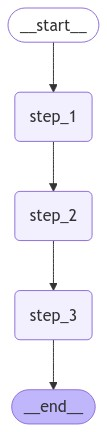

In [1]:
from typing import TypedDict
from IPython.display import Image, display

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt


class State(TypedDict):
    input: str


def step_1(state: State) -> State:
    print("---Step 1---")
    return state


def step_2(state: State) -> State:
    # Let's optionally raise a NodeInterrupt
    # if the length of the input is longer than 5 characters
    if len(state['input']) > 5:
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")
    
    print("---Step 2---")
    return state

def step_3(state: State) -> State:
    print("---Step 3---")
    return state


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Run the graph with dynamic interrupt

First, let's run the graph with an input that <= 5 characters long. This should safely ignore the interrupt condition we defined and return the original input at the end of the graph execution.

In [3]:
initial_input = {"input": "hello"}
thread_config = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello'}
---Step 1---
{'input': 'hello'}
---Step 2---
{'input': 'hello'}
---Step 3---
{'input': 'hello'}


If we inspect the graph at this point, we can see that there are no more tasks left to run and that the graph indeed finished execution.

In [4]:
state = graph.get_state(thread_config)
print(state.next)
print(state.tasks)

()
()


Now, let's run the graph with an input that's longer than 5 characters. This should trigger the dynamic interrupt we defined via raising a `NodeInterrupt` error inside the `step_2` node.

In [5]:
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---
{'input': 'hello world'}


We can see that the graph now stopped while executing `step_2`. If we inspect the graph state at this point, we can see the information on what node is set to execute next (`step_2`), as well as what node raised the interrupt (also `step_2`), and additional information about the interrupt.

In [6]:
state = graph.get_state(thread_config)
print(state.next)
print(state.tasks)

('step_2',)
(PregelTask(id='365d4518-bcff-5abd-8ef5-8a0de7f510b0', name='step_2', error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello world', when='during'),)),)


If we try to resume the graph from the breakpoint, we will simply interrupt again as our inputs & graph state haven't changed.

In [7]:
# NOTE: to resume the graph from a dynamic interrupt we use the same syntax as with regular interrupts -- we pass None as the input
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

In [8]:
state = graph.get_state(thread_config)
print(state.next)
print(state.tasks)

('step_2',)
(PregelTask(id='365d4518-bcff-5abd-8ef5-8a0de7f510b0', name='step_2', error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello world', when='during'),)),)


## Update the graph state

To get around it, we can do several things. 

First, we could simply run the graph on a different thread with a shorter input, like we did in the beginning. Alternatively, if we want to resume the graph execution from the breakpoint, we can update the state to have an input that's shorter than 5 characters (the condition for our interrupt).

In [9]:
# NOTE: this update will be applied as of the last successful node before the interrupt, i.e. `step_1`, right before the node with an interrupt
graph.update_state(config=thread_config, values={"input": "foo"})
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

state = graph.get_state(thread_config)
print(state.next)
print(state.values)

---Step 2---
{'input': 'foo'}
---Step 3---
{'input': 'foo'}
()
{'input': 'foo'}


You can also update the state **as node `step_2`** (interrupted node) which would skip over that node altogether

In [10]:
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": "3"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---
{'input': 'hello world'}


In [11]:
# NOTE: this update will skip the node `step_2` altogether
graph.update_state(config=thread_config, values=None, as_node="step_2")
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

state = graph.get_state(thread_config)
print(state.next)
print(state.values)

---Step 3---
{'input': 'hello world'}
()
{'input': 'hello world'}
